First of all, we were looking for a dataset of iris images. There are many open database (for example UBIRIS, 24-bit color images), but I decided to take own iris dataset, which include 50 people. So let's start by connecting to the database.

In [ ]:
# connection to google drive directory
from google.colab import drive

drive.mount('/content/drive')

The next step is creating a list of iris images names.

In [9]:
import os

path = "/content/drive/MyDrive/Colab Notebooks/IrisDataBaseTrainTest/"
# creating an array of image names
first_list = os.listdir(path)
path_list = [path + s for s in first_list]

In [10]:
path_list[0:6]

['/content/drive/MyDrive/Colab Notebooks/database/img_1_1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/database/img_1_2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/database/img_1_3.jpg',
 '/content/drive/MyDrive/Colab Notebooks/database/img_1_4.jpg',
 '/content/drive/MyDrive/Colab Notebooks/database/img_1_5.jpg',
 '/content/drive/MyDrive/Colab Notebooks/database/img_2_1.jpg']

Before image analyzing, we need to improve quality. So we need to resize, use non-linear filtering, do equalization, change contrast and convert every image to grayscale. We will show each step of image transformation in the following plots.

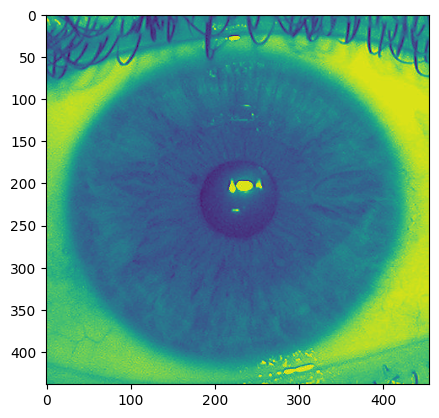

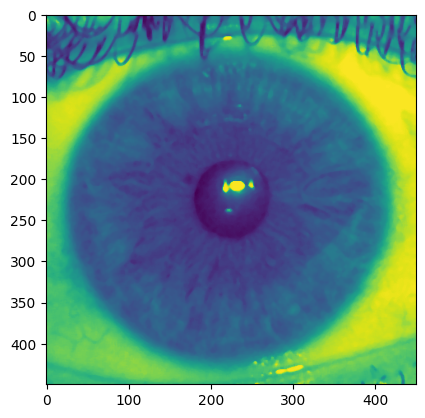

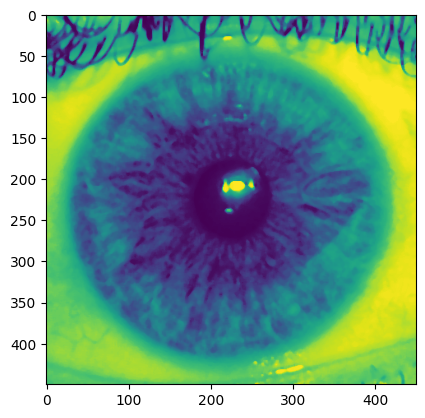

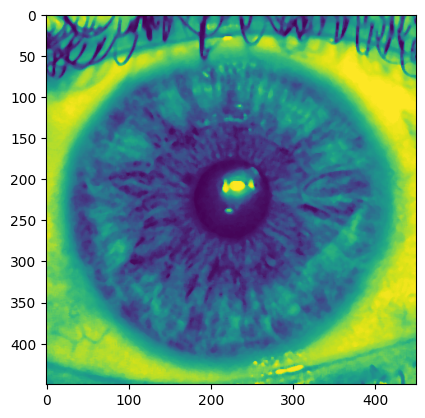

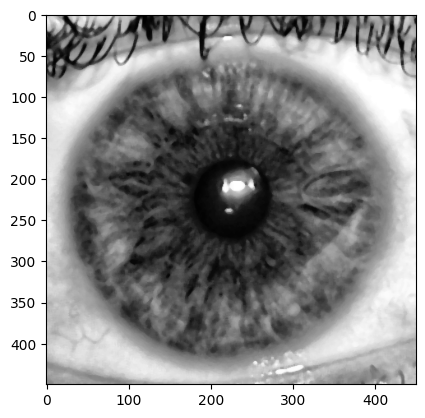

In [19]:
import cv2
import matplotlib.pyplot as plt

image = path_list[0]
# resize
img = cv2.imread(image,0)
plt.figure(); plt.imshow(img)
img = cv2.resize(img, [450, 450])
img = cv2.medianBlur(img,5)
plt.figure(); plt.imshow(img)
# equalization + contrast
equ = cv2.equalizeHist(img)
plt.figure(); plt.imshow(equ)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(equ)
plt.figure(); plt.imshow(clahe_img)
# convert color
cimg = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR)
plt.figure(); plt.imshow(cimg)

The next step is iris recognition from the previous image. We do some preparation to "highlight" boundaries for every image: median filtering, otsu segmentation, sobel filtering and function HoughCircles (OpenCV) to find coordinates of circle (iris).

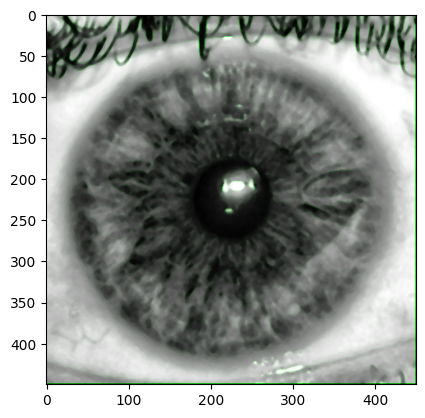

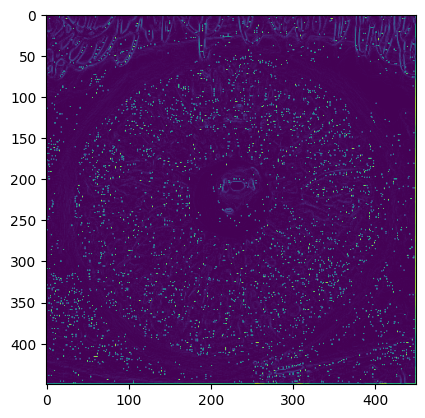

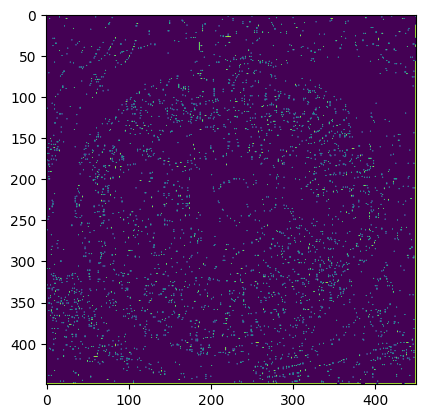

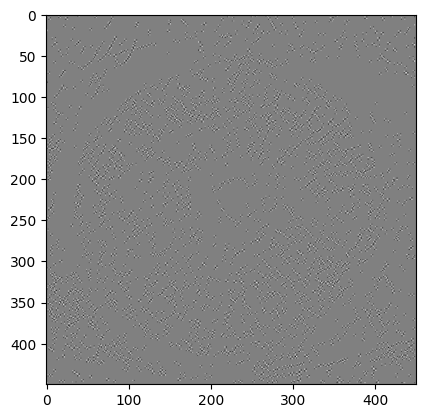

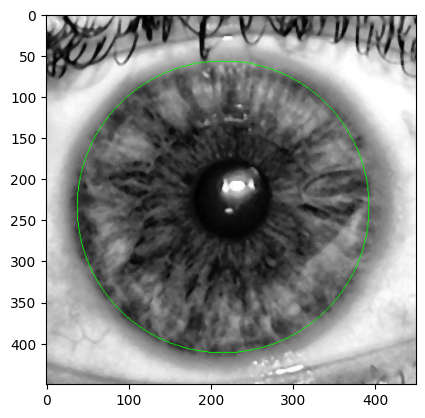

In [20]:
import scipy
import skimage
import numpy as np

# median filtering
filt_orig_3 = scipy.signal.medfilt(cimg, kernel_size=3);
plt.figure(); plt.imshow(filt_orig_3)
diff_image_3 = cimg - filt_orig_3;
diff_image_3 = diff_image_3[:,:,0]
plt.figure(); plt.imshow(diff_image_3)
# segmentation
threshold = skimage.filters.threshold_otsu(diff_image_3)
predicted = np.uint8(diff_image_3 > threshold) * 255
plt.figure(); plt.imshow(predicted)
# sobel filtering
sobel = cv2.Sobel(predicted, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=3)
plt.figure(); plt.imshow(sobel, cmap='gray')
# find circle coordinates
circles = cv2.HoughCircles(sobel.astype(np.uint8),cv2.HOUGH_GRADIENT,1,25,param1=60,param2=40,minRadius=35,maxRadius=210)
# drow circle
cv2.circle(cimg,(int(circles[0,0,0]),int(circles[0,0,1])),int(circles[0,0,2]),(0,255,0))
plt.figure(); plt.imshow(cimg)

This way we can find iris coordinates and radius of image. The next step is transformation of the iris ring from the Cartesian coordinate system into arectangular image in the polar coordinate system, using Daugman normalizaiton.After that, we need to the select of the region of interest (ROI).

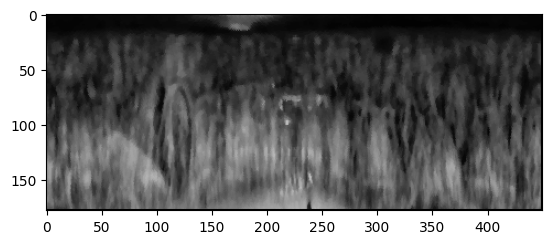

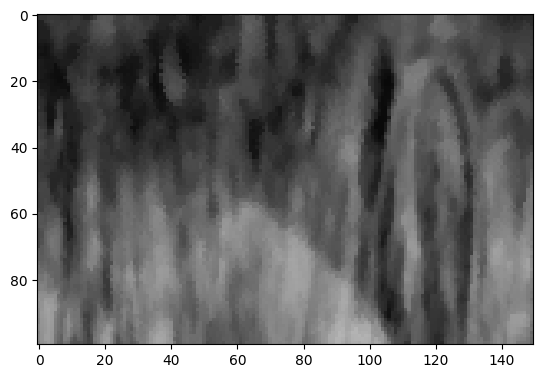

In [22]:
import PIL

def daugman_normalizaiton(image, height, width, r_in, r_out):
    thetas = np.arange(0, 2*np.pi, 2*np.pi/width)
    flat = np.zeros((height,width, 3), np.uint8)
    circle_x = int(image.shape[0] / 2)
    circle_y = int(image.shape[1] / 2)
    for i in range(width-1):
        for j in range(height-1):
            theta = thetas[i]
            r_pro = j / height
            Xi = circle_x + r_in * np.cos(theta)
            Yi = circle_y + r_in * np.sin(theta)
            Xo = circle_x + r_out * np.cos(theta)
            Yo = circle_y + r_out * np.sin(theta)
            Xc = (1 - r_pro) * Xi + r_pro * Xo
            Yc = (1 - r_pro) * Yi + r_pro * Yo
            flat[j][i] = image[int(Xc)][int(Yc)]
    return flat
# daugman normalizaiton
image_nor = daugman_normalizaiton(clahe_img,int(circles[0,0,2]),450,35,int(circles[0,0,2]))
plt.figure(); plt.imshow(image_nor)
# cut region of interest (roi)
image_nor_im = PIL.Image.fromarray(image_nor)
left = 0; right = 150; top = 50; bottom = 150
image_cr = image_nor_im.crop((left, top, right, bottom))
plt.figure(); plt.imshow(image_cr)

The last pre-processing operation is identify the features that characterize the texture of the iris (two-dimensional discrete Fourier transform, two-dimensional discrete cosine transform, and two-dimensional wavelet transform). We will find each parameter and then compare, to find the best one. It's not necessary to analize full parameters area (because of different amplitutes), so we take special range for each set.

In [23]:
from scipy.fft import fft2, fftshift, dct
import pywt
import re
import pandas as pd

# two-dimensional discrete Fourier transform, fft2 \ fftshift
fourier = fftshift(fft2(img))
# two-dimensional discrete cosine transform, dct2
dct_f = dct(dct(np.array(img),norm='ortho'),axis = 0,norm='ortho')
# two-dimensional wavelet transform, wavedec2
coeffs = pywt.wavedec2(img, 'db7', level = 3)
cA3,(_,_,_),(_,_,_),(_,_,_) = coeffs
# computing image class
indexes = re.findall('\d+', first_list[0])
## upload to dataframe
df_2 = pd.DataFrame({'Fourier':  [np.log(abs(fourier)).ravel()],
                     'Dct2':     [np.log(abs(dct_f)).ravel()],
                     'Wawedec2': [(cA3).ravel()],
                     'Class':    [indexes[0]]})

In [26]:
df_2

,Fourier,Dct2,Wawedec2,Class
0,"[4.700480365792416, 5.352773002166429, 5.97361...","[10.949563357222637, 8.579253931329083, 9.5602...","[1280.3158910144641, 1354.050539423101, 1206.4...",1


In this way we identify the features of every image and create one dataFrame with this information.

## **Pre-processing script**

In [ ]:
import os
import re
import PIL
import matplotlib.pyplot as plt
import numpy as np
import skimage
import cv2
from scipy.fft import fft2, fftshift, dct
import pywt
import pandas as pd
import scipy

def daugman_normalizaiton(image, height, width, r_in, r_out):
    thetas = np.arange(0, 2*np.pi, 2*np.pi/width)
    flat = np.zeros((height,width, 3), np.uint8)
    circle_x = int(image.shape[0] / 2)
    circle_y = int(image.shape[1] / 2)
    for i in range(width-1):
        for j in range(height-1):
            theta = thetas[i]
            r_pro = j / height
            Xi = circle_x + r_in * np.cos(theta)
            Yi = circle_y + r_in * np.sin(theta)
            Xo = circle_x + r_out * np.cos(theta)
            Yo = circle_y + r_out * np.sin(theta)
            Xc = (1 - r_pro) * Xi + r_pro * Xo
            Yc = (1 - r_pro) * Yi + r_pro * Yo
            flat[j][i] = image[int(Xc)][int(Yc)]
    return flat

# creating path list
path = "/content/drive/MyDrive/Colab Notebooks/IrisDataBaseTrainTest/"
first_list = os.listdir(path)
first_list.sort()
path_list = [path + s for s in first_list]
# main dataframe
df_main = pd.DataFrame()
# prepearing of data (resize + equalization + drow a circles to each image)
for ii in range(len(path_list)):
    image = path_list[ii]
    # resize
    img = cv2.imread(image,0)
    img = cv2.resize(img, [450, 450])
    img = cv2.medianBlur(img,5)
    # equalization + contrast
    equ = cv2.equalizeHist(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(equ)
    # convert color
    cimg = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR)
    # median filtering
    filt_orig_3 = scipy.signal.medfilt(cimg, kernel_size=3);
    diff_image_3 = cimg - filt_orig_3;
    diff_image_3 = diff_image_3[:,:,0]
    # segmentation
    threshold = skimage.filters.threshold_otsu(diff_image_3)
    predicted = np.uint8(diff_image_3 > threshold) * 255
    # sobel filtering
    sobel = cv2.Sobel(predicted, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=3)
    # find circle coordinates
    circles = cv2.HoughCircles(sobel.astype(np.uint8),cv2.HOUGH_GRADIENT,1,25,param1=60,param2=40,minRadius=35,maxRadius=210)
    # drow circle
    cv2.circle(cimg,(int(circles[0,0,0]),int(circles[0,0,1])),int(circles[0,0,2]),(0,255,0))
    # daugman normalizaiton
    image_nor = daugman_normalizaiton(clahe_img,int(circles[0,0,2]),450,35,int(circles[0,0,2]))
    # cut region of interest (roi)
    image_nor_im = PIL.Image.fromarray(image_nor)
    left = 0; right = 150; top = 50; bottom = 150
    image_cr = image_nor_im.crop((left, top, right, bottom))
    # searching parameters (fft2 \ appcoef2 \ dct2)
    img_arr = np.array(image_cr)
    img = np.zeros([img_arr.shape[0], img_arr.shape[1]])
    img[:, :] = img_arr[:, :, 0]
    # fft2 \ fftshift
    fourier = fftshift(fft2(img))
    # dct2
    dct_f = dct(dct(np.array(img),norm='ortho'),axis = 0,norm='ortho')
    # wavedec2, appcoef2, detcoef2
    coeffs = pywt.wavedec2(img, 'db7', level = 3)
    cA3,(_,_,_),(_,_,_),(_,_,_) = coeffs
    # computing image class
    indexes = re.findall('\d+', first_list[ii])
    ## upload to dataframe
    df_2 = pd.DataFrame({'Fourier':  [np.log(abs(fourier[20:30, 85:115])).ravel()],
                         'Dct2':     [np.log(abs(dct_f[0:10, 0:25])).ravel()],
                         'Wawedec2': [(cA3[10:17, 15:36]).ravel()],
                         'Class':    [indexes[0]]})
    df_main = pd.concat([df_main, df_2], ignore_index=True)

In [6]:
df_main.head()

,Fourier,Dct2,Wawedec2,Class
0,"[6.315972041960337, 5.6615603921000766, 5.9369...","[9.404687197215393, 7.499056328840739, 7.87401...","[771.0780569408525, 637.9557665570194, 617.193...",001
1,"[4.0047033733572945, 6.016676654975291, 5.8204...","[9.392607599197246, 7.483959197579193, 7.86017...","[775.4092796561133, 649.24558956761, 617.46275...",001
2,"[6.095965940195797, 5.886018965066877, 6.15518...","[9.401948612996275, 7.5118508169700995, 7.8773...","[768.3159227331553, 635.3894380118527, 614.496...",001
3,"[6.500590117278792, 5.982496937934766, 6.02420...","[9.404381262722659, 7.494452637229294, 7.87296...","[771.4517662221834, 638.3172449383536, 616.690...",001
4,"[5.8074604127100615, 6.245017298289353, 5.8335...","[9.402176441047747, 7.4978387278681025, 7.8705...","[771.8926424671001, 639.5235333077045, 616.796...",001


Now, we compare features (fft2, dct2, wavedec2) to find the highest accuracy for different classifiers.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix


df_fft = df_main.join(pd.DataFrame(df_main['Fourier'].to_list()))
df_fft = df_fft.drop(['Fourier', 'Dct2', 'Wawedec2'],axis=1)
df_dct = df_main.join(pd.DataFrame(df_main['Dct2'].to_list()))
df_dct = df_dct.drop(['Fourier', 'Dct2', 'Wawedec2'],axis=1)
df_wwd = df_main.join(pd.DataFrame(df_main['Wawedec2'].to_list()))
df_wwd = df_wwd.drop(['Fourier', 'Dct2', 'Wawedec2'],axis=1)
# list of classifiers
Classifiers = {'KNN':  KNeighborsClassifier(),
               'TREE': DecisionTreeClassifier(),
               'RF':   RandomForestClassifier(),
               'LR':   LogisticRegression(),
               'AB':   AdaBoostClassifier(),
               'ETC':  ExtraTreesClassifier(),
               'LDA':  LinearDiscriminantAnalysis(),
               'SVC':  SVC(),
               'GBC':  GradientBoostingClassifier(),
               'GNB':  GaussianNB(),
               'BNB':  BernoulliNB(),
               'LSVC': LinearSVC(),
               'MLP':  MLPClassifier()}
# accuracy dataFrame
df_cr_val = pd.DataFrame(columns=['Model'])
df_cr_val['Model'] = Classifiers.keys()
# compute accuracy of each classifier
for ii in range(3):
    if   ii == 0: df_N = df_fft
    elif ii == 1: df_N = df_dct
    elif ii == 2: df_N = df_wwd
    # train_test_split + stratify
    X_train, X_test, y_train, y_test = train_test_split(df_N.drop('Class',axis=1),
                                                        df_N['Class'],
                                                        test_size=0.2,
                                                        random_state=42,
                                                        stratify=df_N['Class'])
    # compute accuracy
    cr_val_aver = []; accuracy = []
    for name in Classifiers.values():
      name.fit(X_train, y_train)
      # cross validation
      cr_val_aver.append(np.mean(cross_validate(name,
                                                df_N.drop('Class',axis=1),
                                                df_N['Class'].values, cv = 5)['test_score']))
      # accuracy classification score
      accuracy.append(accuracy_score(y_test, name.predict(X_test)))
    titl = 'fft'*(ii==0)+'dct'*(ii==1)+'wave'*(ii==2)
    # fill dataFrame
    df_cr_val['mean_test_score_'+titl] = cr_val_aver
    df_cr_val['accuracy_'+titl] = accuracy
    #df_cr_val = df_cr_val.sort_values(by = 'mean_test_score', ascending=False)

In [12]:
df_cr_val = df_cr_val.sort_values(by = 'mean_test_score_fft', ascending=False)
df_cr_val

,Model,mean_test_score_fft,accuracy_fft,mean_test_score_dct,accuracy_dct,mean_test_score_wave,accuracy_wave
7,SVC,0.244279,0.477612,0.923383,0.995025,0.980597,0.995025
0,KNN,0.171144,0.388060,0.891542,0.977612,0.969154,0.990050
2,RF,0.162687,0.328358,0.970647,0.997512,0.974129,0.997512
6,LDA,0.160199,0.360697,0.941791,0.990050,0.904975,0.982587
9,GNB,0.154726,0.333333,0.673632,0.905473,0.876617,0.982587
3,LR,0.141791,0.340796,0.937811,0.990050,0.944776,0.990050
5,ETC,0.139801,0.315920,0.953234,0.997512,0.976617,0.997512
11,LSVC,0.132836,0.308458,0.937811,0.990050,0.947264,0.990050
8,GBC,0.073632,0.161692,0.779104,0.915423,0.766169,0.947761
1,TREE,0.066667,0.176617,0.741294,0.898010,0.751741,0.898010


In [13]:
df_cr_val = df_cr_val.sort_values(by = 'mean_test_score_dct', ascending=False)
df_cr_val

,Model,mean_test_score_fft,accuracy_fft,mean_test_score_dct,accuracy_dct,mean_test_score_wave,accuracy_wave
2,RF,0.162687,0.328358,0.970647,0.997512,0.974129,0.997512
5,ETC,0.139801,0.315920,0.953234,0.997512,0.976617,0.997512
6,LDA,0.160199,0.360697,0.941791,0.990050,0.904975,0.982587
3,LR,0.141791,0.340796,0.937811,0.990050,0.944776,0.990050
11,LSVC,0.132836,0.308458,0.937811,0.990050,0.947264,0.990050
7,SVC,0.244279,0.477612,0.923383,0.995025,0.980597,0.995025
0,KNN,0.171144,0.388060,0.891542,0.977612,0.969154,0.990050
12,MLP,0.020896,0.019900,0.843284,0.965174,0.644776,0.194030
8,GBC,0.073632,0.161692,0.779104,0.915423,0.766169,0.947761
1,TREE,0.066667,0.176617,0.741294,0.898010,0.751741,0.898010


In [14]:
df_cr_val = df_cr_val.sort_values(by = 'mean_test_score_wave', ascending=False)
df_cr_val

,Model,mean_test_score_fft,accuracy_fft,mean_test_score_dct,accuracy_dct,mean_test_score_wave,accuracy_wave
7,SVC,0.244279,0.477612,0.923383,0.995025,0.980597,0.995025
5,ETC,0.139801,0.315920,0.953234,0.997512,0.976617,0.997512
2,RF,0.162687,0.328358,0.970647,0.997512,0.974129,0.997512
0,KNN,0.171144,0.388060,0.891542,0.977612,0.969154,0.990050
11,LSVC,0.132836,0.308458,0.937811,0.990050,0.947264,0.990050
3,LR,0.141791,0.340796,0.937811,0.990050,0.944776,0.990050
6,LDA,0.160199,0.360697,0.941791,0.990050,0.904975,0.982587
9,GNB,0.154726,0.333333,0.673632,0.905473,0.876617,0.982587
8,GBC,0.073632,0.161692,0.779104,0.915423,0.766169,0.947761
1,TREE,0.066667,0.176617,0.741294,0.898010,0.751741,0.898010


We got the next results:

1) highest accuracy for fft2 = SVC, 0.244279;

2) highest accuracy for dct2 = RF, 0.970647;

3) highest accuracy for wavedec2 = SVC, 0.980597.
So, final model will be based on SVC classifier (due tp the highest accuracy).

Now, let's show confusion matrix.

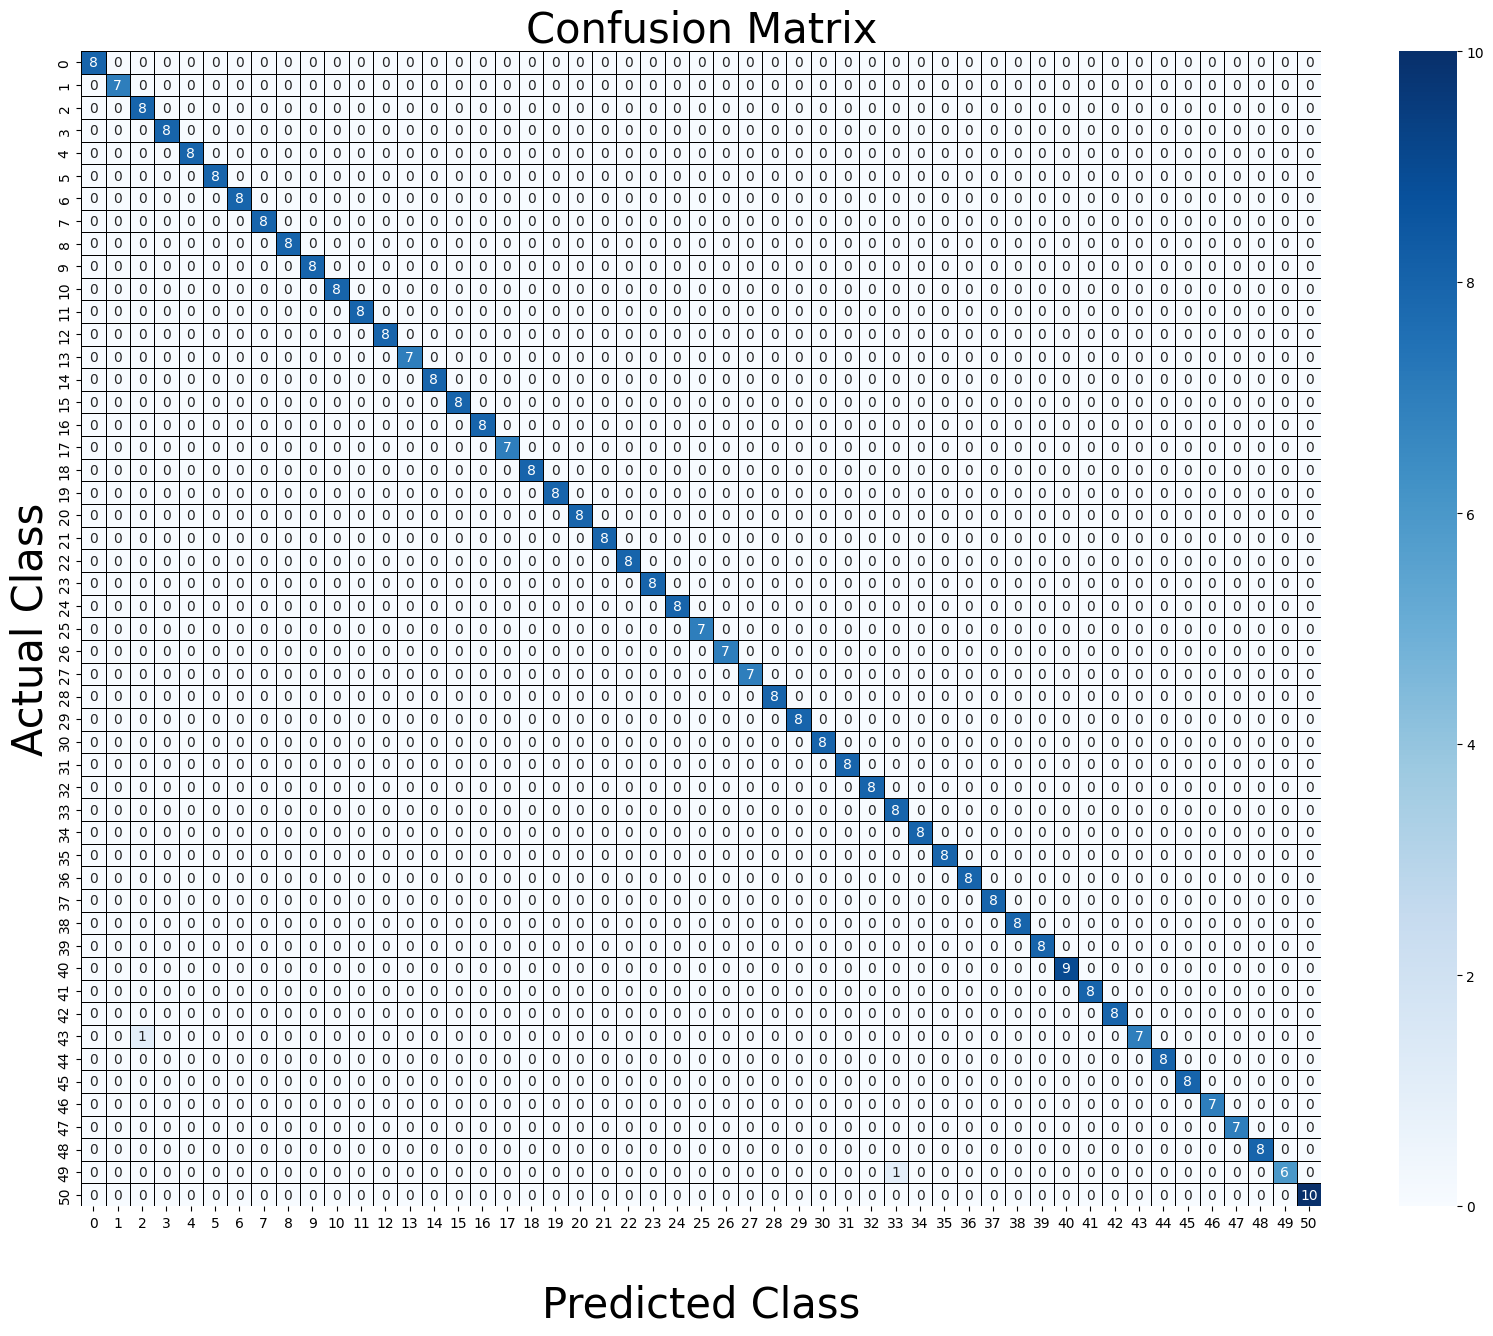

In [15]:
import seaborn as sns

# compute confusion matrix
classifier = SVC()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
# plot confusion matrix
plt.figure(figsize=(20,15))
ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', annot_kws={'size': 10}, linewidth=0.5, linecolor='black')
ax.set_title('Confusion Matrix', fontsize=30);
ax.set_xlabel('\nPredicted Class', fontsize=30)
ax.set_ylabel('Actual Class', fontsize=30);
plt.show()

The final step is finding the best parameters of classifier. We will make it using GridSearchCV and then save our model.

In [20]:
from sklearn.model_selection import GridSearchCV
import pickle

# select \ search best parameters
params = [{'tol': [1e-3, 1e-4],
           'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
           'random_state': [0, 42],
           'C': [1, 1.1, 1.2]}]
clf = GridSearchCV(SVC(), params, scoring='accuracy', n_jobs = -1)
grid_search = clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)
# final version of model
model = SVC(tol=0.001,random_state=0,kernel='linear',C = 1, probability=True)
model.fit(X_train, y_train)
filename = 'finalized_model_SVC.sav'
pickle.dump(model, open(filename, 'wb'))

{'C': 1, 'kernel': 'linear', 'random_state': 0, 'tol': 0.001}
0.9981327760685745


And now, let's test our model, using iris images, that were not included in train_test database.

In [ ]:
import os
import re
import PIL
import numpy as np
import skimage
import cv2
import pywt
import pandas as pd
import scipy
import pickle
from collections import Counter

def daugman_normalizaiton(image, height, width, r_in, r_out):
    thetas = np.arange(0, 2*np.pi, 2*np.pi/width)
    flat = np.zeros((height,width, 3), np.uint8)
    circle_x = int(image.shape[0] / 2)
    circle_y = int(image.shape[1] / 2)
    for i in range(width-1):
        for j in range(height-1):
            theta = thetas[i]
            r_pro = j / height
            Xi = circle_x + r_in * np.cos(theta)
            Yi = circle_y + r_in * np.sin(theta)
            Xo = circle_x + r_out * np.cos(theta)
            Yo = circle_y + r_out * np.sin(theta)
            Xc = (1 - r_pro) * Xi + r_pro * Xo
            Yc = (1 - r_pro) * Yi + r_pro * Yo
            flat[j][i] = image[int(Xc)][int(Yc)]
    return flat

# creating path list
loaded_model = pickle.load(open('/content/finalized_model_SVC.sav', 'rb'))
path = '/content/drive/MyDrive/Colab Notebooks/IrisDataBaseTestID/'
first_list_test = os.listdir(path)
path_list_test = [path + s for s in first_list_test]
# choose any photo \ image
image = path_list_test[0]
# resize
img = cv2.imread(image,0)
img = cv2.resize(img, [450, 450])
img = cv2.medianBlur(img,5)
# equalization + contrast
equ = cv2.equalizeHist(img)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(equ)
# convert color
cimg = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR)
# median filtering
filt_orig_3 = scipy.signal.medfilt(cimg, kernel_size=3);
diff_image_3 = cimg - filt_orig_3;
diff_image_3 = diff_image_3[:,:,0]
# segmentation
threshold = skimage.filters.threshold_otsu(diff_image_3)
predicted = np.uint8(diff_image_3 > threshold) * 255
# sobel filtering
sobel = cv2.Sobel(predicted, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=3)
# find circle coordinates
circles = cv2.HoughCircles(sobel.astype(np.uint8),cv2.HOUGH_GRADIENT,1,25,param1=60,param2=40,minRadius=35,maxRadius=210)
# drow circle
cv2.circle(cimg,(int(circles[0,0,0]),int(circles[0,0,1])),int(circles[0,0,2]),(0,255,0))
# daugman normalizaiton
image_nor = daugman_normalizaiton(clahe_img,int(circles[0,0,2]),450,35,int(circles[0,0,2]))
# cut region of interest (roi)
image_nor_im = PIL.Image.fromarray(image_nor)
left = 0; right = 150; top = 50; bottom = 150
image_cr = image_nor_im.crop((left, top, right, bottom))
# searching parameters (fft2 \ appcoef2 \ dct2)
img_arr = np.array(image_cr)
img = np.zeros([img_arr.shape[0], img_arr.shape[1]])
img[:, :] = img_arr[:, :, 0]
# wavedec2, appcoef2, detcoef2
coeffs = pywt.wavedec2(img, 'db7', level = 3)
cA3,(cH3,cV3,cD3),(cH2,cV2,cD2),(cH1,cV1,cD1) = coeffs
# computing image class
indexes = re.findall('\d+', first_list[ii])
## upload to dataframe
df_main = pd.DataFrame([(cA3[10:17, 15:36]).ravel()])
# prediction
new_res = loaded_model.predict_proba(df_main)
df_res = pd.DataFrame({'Class': loaded_model.classes_,
                       'Percentage': Counter(100*new_res.ravel()).keys()})
df_res = df_res.sort_values(by='Percentage', ascending=False)

In [30]:
df_res

,Class,Percentage
10,011,61.861845
9,010,4.917333
26,027,4.914436
36,037,2.623771
0,001,2.264646
24,025,2.029611
32,033,2.017452
35,036,1.867409
25,026,1.404886
37,038,1.313754


## **Conclusion**

So, the best classifier (in our case) is SVC with 98% accuracy. We tested the model with a new image (not from the train_test database) and saw the highest prediction on the percentage scale.